# Reinforcement Learning

This tutorial is a modified version of pytorch's own Reinforcement Learning [tutorial](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html).

Simply put, reinforcement learning is the cyclical process of Reward = State * Action. In psychological terms, the process is most akin to [positive reinforcement](https://en.wikipedia.org/wiki/Reinforcement#Positive_reinforcement), in which a subject is given a reward for completing a simple goal in order to increase the likelihood of doing said goal. 

Reinforcement learning is similar in that we intend to maximize a reward by promoting a given behavior, although we break down our ultimate goal into smaller actions, giving rewards along the way. Each action is made in response to a state, or the current conditions of the environment. 

But how do we know the current condtions of the environment? Or put another way, how can we make a statistical model to optimize a reward? We use a neural network. The beauty in this is it also allows the AI to act on inference given knowledge of similar states, as an neural network can approximate any statistical model, including the that of action, state, and reward.

Let's see this is in action (ba-dum-tss)...

# Setting Up Packages

We begin by collecting the ```pip``` package **gym**. Gym is a collection of environments made by OpenAI that can be used to train our neural network. In this case, we will build our model based on their atari clones. Specifically, [Atari Breakout](https://gym.openai.com/envs/Breakout-v0/).

If not in colab, run ```pip install gym```.

Next we import our libraries:

In [2]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


env = gym.make('Breakout-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Replay Memory

Replay memory is our means of storing information about prior states and what was done to maximize rewards in a given state. This gives us the ability to compute inference of the current state faster, as well as have a successful model faster.
For this we need two objects:


*   **Transition**: This is a named tuple that demonstrates to the AI what the concequences will be given the state and action.
*   **Replay Memory**: A means of storing a sequence of transitions and sampling them at random for training.


In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


# Q-Network

This is the main neural network we will be running. The most critical idea to take away from it is the number of outputs must equal the total number of possible number of moves for a game controller. This way, we can predict the action (or move) that gives the highest reward. In this case, our moves include left and right.

In [4]:
class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        # Input dimension of 1 because color doesn't really matter
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, stride=2)
        self.fc1 = nn.Linear(1472 * 17, 256)
        self.head = nn.Linear(256, 2)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = (x.view(-1,1472 * 17))
        x = F.relu(self.fc1(x))
        return self.head(x.view(x.size(0), -1))


# Scene Extraction

Below is the code we use to grab the screen for input into the Q-Network.

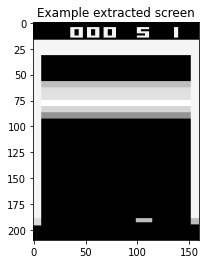

In [5]:
resize = T.Compose([T.ToPILImage(),
                    T.Grayscale(),
                    T.ToTensor()])

def get_screen():

    screen = env.render(mode="rgb_array").transpose((2, 0, 1))
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)

# Extracted Scene
env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(1).squeeze(0).numpy(), cmap="gray")
plt.title('Example extracted screen')
plt.show()

# Utilities

To train our model, we will rely on both past experience and randomness. The element of randomness allows us to find new methods not previously discovered. This can be useful, but eventually, we want the element of randomness to decay.

Our measurement of success is the length of time our player stays alive.

In [6]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())


# Training

At last, we train and optimize our model. For those curious, we use a different loss function known as Huber Loss as it reduces noise of outliers, behaving as different losses depending on the situation.

In [8]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(0, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()


Finally, we enter the main training loop. We run through the episodes, and display the final one. Cograts on making it this far!

In [15]:
# Similar to epochs
num_episodes = 10
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
    print(i_episode)
print('Complete')


<Figure size 432x288 with 0 Axes>

9
Complete


<Figure size 432x288 with 0 Axes>

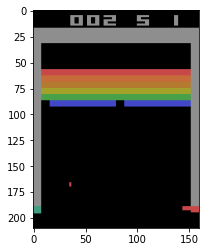

In [16]:
env.reset()

for i in range(120):
   plt.imshow(env.render(mode='rgb_array'))
   display.display(plt.gcf())    
   display.clear_output(wait=True)
   env.step(env.action_space.sample()) # take a random action

env.close()